<a href="https://colab.research.google.com/github/tmannem/CovidPOC/blob/master/covidprophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Stuff. Regular Nothing Big. Just adding Prophet here
Lots to be done
Code learnt from 
https://towardsdatascience.com/predicting-the-future-with-facebook-s-prophet-bdfe11af10ff

In [0]:
import pandas as pd
#pd.set_option('display.max_columns', None)
import numpy as np
from fbprophet import Prophet
%matplotlib inline
import matplotlib.pyplot as plt
import io
#sample=

Read it Blah blah blah
This is the actual Data set

In [32]:

df2 = pd.read_csv('/var/data/full_data.csv')
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8597 entries, 0 to 8596
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          8597 non-null   object
 1   location      8597 non-null   object
 2   new_cases     8597 non-null   int64 
 3   new_deaths    8597 non-null   int64 
 4   total_cases   8597 non-null   int64 
 5   total_deaths  8597 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 403.1+ KB


**** Filter only the world counts. For this POC that is what I wanted
The end goal is to create a map predicting it based on the location. Looks like Prophet is more one-D based. Need to see how we can include locations also in predicting ****


In [33]:
df2 = df2[df2['location']=='World']
df2.to_csv('groupedData1.csv')
df2['date'] = pd.to_datetime(df2['date'])
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95 entries, 8472 to 8566
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          95 non-null     datetime64[ns]
 1   location      95 non-null     object        
 2   new_cases     95 non-null     int64         
 3   new_deaths    95 non-null     int64         
 4   total_cases   95 non-null     int64         
 5   total_deaths  95 non-null     int64         
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 5.2+ KB


** This is what we need where I get only the cases related to the count **

In [34]:
df3 = df2.groupby("date").total_cases.sum().reset_index()
#df3['date'] = pd.to_datetime(df2['date'])
df3.head()
df3.sort_values(by='date', ascending='true')


,date,total_cases
0,2019-12-31,27
1,2020-01-01,27
2,2020-01-02,27
3,2020-01-03,44
4,2020-01-04,44
...,...,...
90,2020-03-30,715353
91,2020-03-31,777796
92,2020-04-01,851308
93,2020-04-02,928436


**plot blah blah**

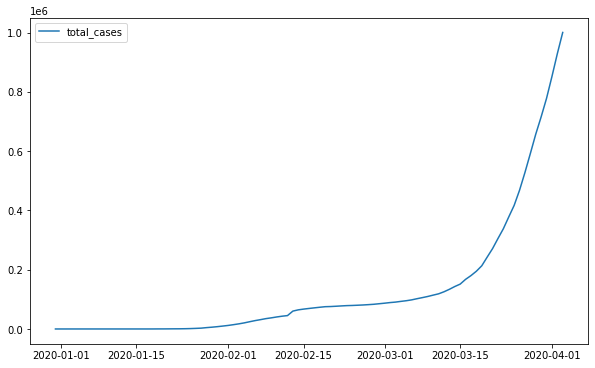

In [35]:
plt.figure(figsize=(10,6))
plt.plot(df3.set_index('date'))
plt.legend(['total_cases'])

Need to investigate why Prophet needs data in this format

In [38]:
df3.columns = ['ds','y']
df3.head()

,ds,y
0,2019-12-31,27
1,2020-01-01,27
2,2020-01-02,27
3,2020-01-03,44
4,2020-01-04,44


**Seasonality. I changed it to False**

In [52]:
m1 = Prophet(daily_seasonality=False)
m1.fit(df3)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


**Now run this model**

In [46]:
future1 = m1.make_future_dataframe(periods=30)
forecast1 = m1.predict(future1)
forecast1.tail().T

,120,121,122,123,124
ds,2020-04-29 00:00:00,2020-04-30 00:00:00,2020-05-01 00:00:00,2020-05-02 00:00:00,2020-05-03 00:00:00
trend,1.86748e+06,1.90616e+06,1.94484e+06,1.98353e+06,2.02221e+06
yhat_lower,1.74145e+06,1.7838e+06,1.81512e+06,1.84202e+06,1.88171e+06
yhat_upper,1.95268e+06,2.0053e+06,2.05004e+06,2.08952e+06,2.12755e+06
trend_lower,1.76928e+06,1.8013e+06,1.83346e+06,1.86707e+06,1.89991e+06
trend_upper,1.96279e+06,2.00791e+06,2.05245e+06,2.09851e+06,2.14325e+06
additive_terms,-15420.5,-12285.4,-8796.53,-18508.2,-16536.8
additive_terms_lower,-15420.5,-12285.4,-8796.53,-18508.2,-16536.8
additive_terms_upper,-15420.5,-12285.4,-8796.53,-18508.2,-16536.8
daily,-15002.8,-15002.8,-15002.8,-15002.8,-15002.8


In [47]:
forecast1[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
120,2020-04-29,1.852055e+06,1.741448e+06,1.952676e+06
121,2020-04-30,1.893874e+06,1.783795e+06,2.005304e+06
122,2020-05-01,1.936048e+06,1.815115e+06,2.050044e+06
123,2020-05-02,1.965021e+06,1.842018e+06,2.089518e+06
124,2020-05-03,2.005677e+06,1.881712e+06,2.127547e+06


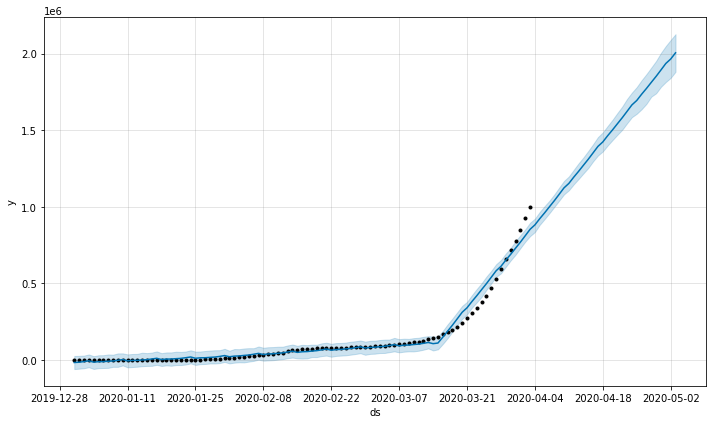

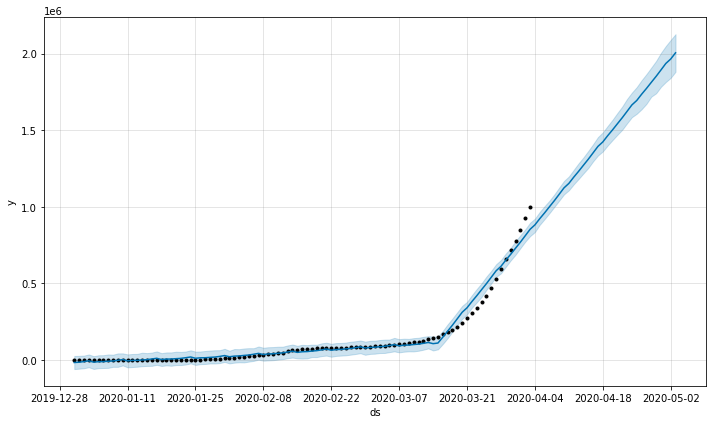

In [48]:
m1.plot(forecast1)

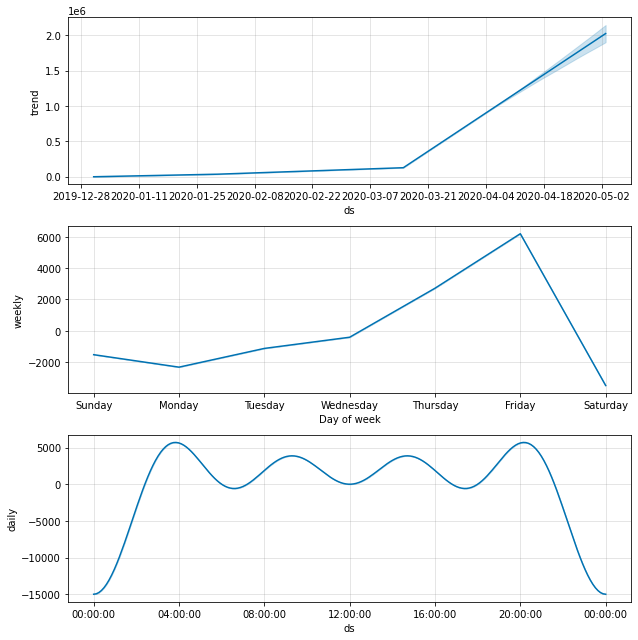

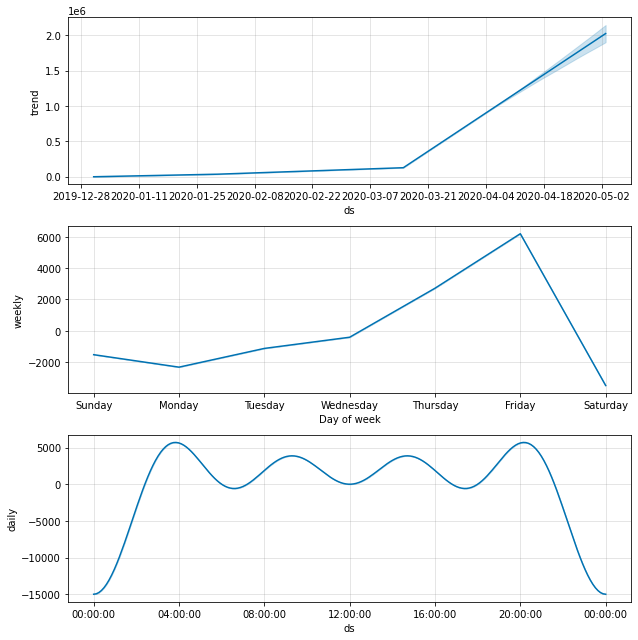

In [49]:
m1.plot_components(forecast1)

In [61]:
future1 = m1.make_future_dataframe(periods=10)
forecast2 = m1.predict(future1)
forecast2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
forecast2['total_cases']=pd.to_numeric(forecast2.yhat)
#forecast2['total_cases']
#forecast2["total_cases"] = np.exp(forecast2.yhat).round()
forecast2["total_cases_lower"] = forecast2.yhat_lower
forecast2["total_cases_upper"] = forecast2.yhat_upper
forecast2[(forecast2.ds > "04-03-2020") &(forecast2.ds < "4-07-2020")][["ds","total_cases_lower","total_cases", "total_cases_upper"]]

,ds,total_cases_lower,total_cases,total_cases_upper
95,2020-04-04,839118.920763,882286.347463,9.233973e+05
96,2020-04-05,879766.912733,923004.734277,9.629370e+05
97,2020-04-06,919916.632252,960946.860293,1.003819e+06
